In [1]:
%matplotlib inline
from astropy import units as u
from astropy import constants
import pyradex

Defining terms:

 * temperature : the kinetic temperature of the gas
 * $T_{ex}$ or `Tex` : the excitation temperature of the given transition
 * $T_{bg}$ or `Tbg` : the background radiation temperature (generally, $T_{CMB}=2.7315$)

In [2]:
# H2CO dipole moment
dipole_moment = 2.331*u.Debye*(1e-18*u.esu*u.cm/u.Debye)
# 1 Debye = 1e-18 esu

In [3]:
def Jnu(nu, T):
    """RJ equivalent temperature (eqn 24)"""
    return constants.h*nu/constants.k_B / (np.exp(constants.h*nu/(constants.k_B*T))-1)

In [4]:
R = pyradex.Radex(species='oh2co-h2', density=1e3, temperature=20, column=1e12)
def Qrot(temperature, R=R):
    return R.partition_function(temperature)

/Users/adam/repos/pyradex/pyradex/core.py:506: UserWarning: Using a default ortho-to-para ratio (which will only affect species for which independent ortho & para collision rates are given)
  warnings.warn("Using a default ortho-to-para ratio (which "


In [5]:
def Nu(line_strength, frequency, temperature, tau_integral):
    """Eqn 30"""
    return (3*constants.h/(8*np.pi**3 * line_strength**2) *
            (np.exp(constants.h*frequency/(constants.k_B*temperature)))**-1 *
            tau_integral)

In [6]:
def Ntot(degeneracy_u, **kwargs):
    """Eqn 32"""
    return (Nu(**kwargs) * Qrot(temperature)/degeneracy_u * np.exp(Eu/(constants.k_B * Tex)))

In [7]:
def Nthintot(nu, line_integral, degeneracy_u, line_strength, temperature, Eu, Tex, Tbg=2.7315*u.K, fillingfactor=1.0):
    """Eqn 80, where S mu^2 R_i = line_strength^1/2  because R_i = relative strength of hyperfines = 1"""
    term1 = (3*constants.h/(8*np.pi**3 * line_strength**2))
    term2 = Qrot(temperature)/degeneracy_u 
    term3 = np.exp(Eu/(constants.k_B * Tex)) / (np.exp(constants.h*nu/(constants.k_B * Tex)) - 1)
    term4 = 1./(Jnu(nu,Tex)-Jnu(nu,Tbg))
    term5 = line_integral.to(u.K*u.km/u.s) / fillingfactor
    return term1 * term2 * term3 * term4 * term5

In [8]:
def NNotThintot(tau, *args, **kwargs):
    """Eqn 85 & 86"""
    term = tau / (1-np.exp(-tau))
    return Nthintot(*args, **kwargs) * term

In [9]:
nu=5*u.GHz
Tex=25*u.K
(constants.h*nu/(constants.k_B * Tex)).decompose()
R.upperstateenergy[2]*u.K*constants.k_B/(constants.k_B * Tex)

<Quantity 0.904>

In [10]:
from astroquery.splatalogue import Splatalogue
h2co22 = Splatalogue.query_lines(R.frequency[2]*0.999, R.frequency[2]*1.001, line_strengths=['ls1','ls2','ls3','ls4','ls5'],
                                 chemical_name=' H2CO ')
line_strength = float(h2co22[h2co22['Linelist']=='JPL']['S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>)'])*u.esu*u.cm
line_strength

<Quantity 13.58489 cm Fr>

In [11]:
Nthintot(nu=R.frequency[2], 
         line_integral=277*u.K*u.km/u.s,
         degeneracy_u=R.statistical_weight[2], 
         line_strength=line_strength, 
         temperature=25*u.K,
         Eu=R.upperstateenergy[2]*u.K*constants.k_B,
         Tex=25*u.K,
        ).to(u.cm**-2)

/Users/adam/repos/pyradex/pyradex/core.py:1003: UserWarning: The partition function may be very inaccurate using LAMDA files because they include a small fraction of the total available states.
  warnings.warn("The partition function may be very inaccurate using "


<Quantity 2.172627839556555e-22 1 / cm2>

Equation 58: Approximation to $Q_{rot}$ for a slightly asymmetric rotor
$$Q_{rot} = \frac{1}{\sigma} \left[m \pi \left(\frac{kT}{hB_0}\right)^3\right]^{1/2}$$

$\sigma$ is the number of identical nuclei (3 for NH$_3$, 2 for H$_2$CO, etc)

$m = B_0/C_0$ for a limiting oblate molecule like NH$_3$

$m=B_0^2/(A_0C_0)$ for a slightly asymmetric rotor like H$_2$CO

Equation 30:
$$N_u = \frac{3h}{8\pi^2|\mu_{ul}|^2} \left[\exp(-h\nu/k T)-1\right]^{-1} \int \tau_{\nu} dv$$

Equation 78, rearranged (f is the filling factor):
$$\tau_\nu = \frac{T_B}{f \left(J_\nu(T_{ex}) - J_\nu(T_{bg}) \right)}$$

Together, plus the assumption that goes into eqn 80:
$$N_u = \frac{3h}{8\pi^2|\mu_{ul}|^2} \left[\exp(-h\nu/k T)-1\right]^{-1} \frac{\int T_B dv}{f \left(J_\nu(T_{ex}) - J_\nu(T_{bg}) \right)}$$

Using the Rayleigh-Jeans radiation temperature, we get:

$$N_u = \frac{3h}{8\pi^2 |\mu_{ul}|^2} \left[\exp(-h\nu/k T)-1\right]^{-1} \frac{\int T_B dv}{f \left(T_{ex} - T_{bg} \right)}$$



This can be converted to the "not optically thin" version as in equation 86:
$$N_u = \frac{3h}{8\pi^2 |\mu_{ul}|^2} \left[\exp(-h\nu/k T)-1\right]^{-1} \frac{\int T_B dv}{f \left(T_{ex} - T_{bg} \right)} \frac{\tau}{1-e^{-\tau}}$$

In the high $T_{ex}$ limit, two approximations hold:

 1. $T_{ex} - T_{bg} \approx T_{ex}$
 2. $(\exp(-h\nu/(k T)) -1)^{-1} \approx k T / h \nu$
 



Applied to the previous equation:

$$N_u = \frac{3h}{8\pi^2 |\mu_{ul}|^2} \left[\frac{k T_{ex}}{h \nu}\right]_{unitless} \frac{\int T_B dv}{f \left(T_{ex} \right)} \frac{\tau}{1-e^{-\tau}}$$

a lot cancels, resulting in:

$$N_u = \frac{3 k}{8\pi^2 \nu |\mu_{ul}|^2} \frac{\int T_B dv}{f}$$
or, tau-corrected,
$$N_u = \frac{3 k}{8\pi^2 \nu |\mu_{ul}|^2} \frac{\int T_B dv}{f} \frac{\tau}{1-e^{-\tau}}$$



## Boltzmann Diagram: ##

Equation 31 gives:
$$\frac{N_{tot}}{N_{u}} = \frac{Q_{rot}}{g_u} \exp({E_u/k T})$$

Which yields the fittable "Boltzmann Diagram" equation (if $N_u$ is independent from $T_{ex}$, as in the above approximation):
$$N_u = N_{tot} \frac{g_u}{Q_{rot}} \exp({-E_u/kT})$$
Taking the log of both sides:
$$\ln (N_u/g_u) = \ln N_{tot} - \ln Q_{rot} - \frac{E_u}{k T}$$
which is a linear equation of the form $y=mx+b$ where

 * $y = \ln (N_u/g_u)$ 
 * $m = -\frac{1}{kT}$
 * $b = \ln N_{tot} - \ln Q_{rot}$

$$N_u(\tau<<1) = \frac{3 h}{8 \pi^2 \left|\mu\right|^2} \left[\exp{h\nu/k_B T_{ex}} - 1\right]^{-1} \left(T_{ex}-T_{bg}\right)^{-1}\frac{\tau}{1-e^{-\tau}} \int \frac{T_R dv}{f}$$ 

In [ ]:
def Nu_thin(flux, line_strength, tex, freq, Tbg=2.7315*u.K, fillingfactor=1.0, tau=None):
    """
    Derived from Eqn 30 + Eqn 80 of Mangum 2015
    """
    assert flux.unit.is_equivalent(u.K*u.km/u.s)
    assert line_strength.unit.is_equivalent(u.esu*u.cm)
    hnu = constants.h * freq
    h = constants.h
    kbt = constants.k_B * tex
    # changed term1 to pi^3... think it was just a typo (July 11, 2017)
    term1 = (3*h/(8*np.pi**3 * line_strength**2))
    term3 = 1. / (np.exp(hnu/kbt) - 1)
    term4 = 1./(tex-Tbg)
    term5 = flux.to(u.K*u.km/u.s) / fillingfactor
    term6 = 1 if tau is None else tau/(1-np.exp(-tau))
    return (term1*term3*term4*term5*term6).to(u.cm**-2)

In [13]:
Nu_thin(1*u.km/u.s*u.K, 96**0.5*1e-18*u.esu*u.cm, 175*u.K, 25.05603*u.GHz).decompose()

<Quantity 2207854549278212.5 1 / m2>

latex version of next eqn:
$$N_u(\tau<<1; T_{ex} >> h\nu) = \frac{3 k_B}{8\pi^2 \nu \left|\mu\right|^2} \frac{\tau}{1-e^{-\tau}} \int \frac{T_R dv}{f}$$

In [14]:
def Nu_thin_hightex(flux, line_strength, freq, fillingfactor=1.0, tau=None):
    """
    Optically-thin-ish approximation for the column density of the upper state
    of a given line assuming T_ex >> T_bg and T_ex >> h nu
    """
    assert flux.unit.is_equivalent(u.K*u.km/u.s)
    assert line_strength.unit.is_equivalent(u.esu*u.cm)
    k = constants.k_B
    term1 = (3*k/(8*np.pi**3 * freq * line_strength**2))
    term5 = flux.to(u.K*u.km/u.s) / fillingfactor
    term6 = 1 if tau is None else tau/(1-np.exp(-tau))
    return (term1*term5*term6).to(u.cm**-2)

In [15]:
Nu_thin_hightex(1*u.km/u.s*u.K, 96**0.5*1e-18*u.esu*u.cm, freq=25.05603*u.GHz).decompose()

<Quantity 2180877383395417.2 1 / m2>

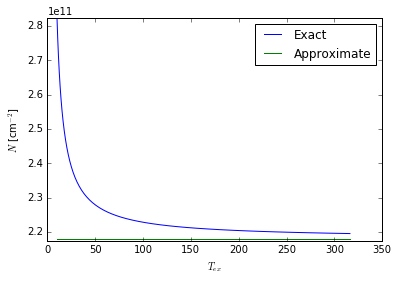

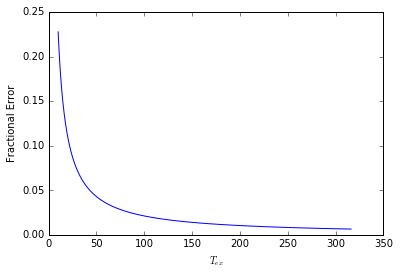

In [16]:
tex = np.logspace(1,2.5)
nuthin = Nu_thin(1*u.km/u.s*u.K, 96**0.5*1e-18*u.esu*u.cm, tex*u.K, 25.05603*u.GHz)
nuthin_approx = Nu_thin_hightex(1*u.km/u.s*u.K, 96**0.5*1e-18*u.esu*u.cm, freq=25.05603*u.GHz)
import pylab as pl
pl.plot(tex, nuthin, label="Exact")
pl.plot(tex, nuthin_approx*np.ones(len(tex)), label="Approximate")
pl.legend(loc='best')
pl.xlabel("$T_{ex}$")
pl.ylabel("$N$ [cm$^{-2}$]")
pl.ylim(nuthin.value.min()*0.99, nuthin.value.max())

pl.figure()
pl.plot(tex, (nuthin-nuthin_approx)/nuthin)
pl.ylabel("Fractional Error")
pl.xlabel("$T_{ex}$")


In [17]:
ls ~/LAMDA

13co.dat	find_h2_names.py  ipython_log_2014-08-28.py  oh2o@daniel.dat
13cs@xpol.dat	h13cn@xpol.dat	  n2h+_hfs.dat		     oh@hfs.dat
29sio.dat	h13co+@xpol.dat   nh3.dat		     p-c3h2.dat
40ArHp.dat	h2co-h2.dat	  no.dat		     p-h2co.dat
a-ch3oh.dat	h2co.dat	  o-c3h2.dat		     p-h2o-combined.dat
astropy.log	hc15n@xpol.dat	  o-h2co-green.dat	     p-h3o+.dat
c+@uv.dat	hc17o+@xpol.dat   o-h2co-h2_faure.dat	     p-nh3.dat
c17o.dat	hc18o+@xpol.dat   o-h2co-old.dat	     ph2co-h2.dat
c18o.dat	hc3n-h2.dat	  o-h2co-scaled1.6.dat	     ph2co.dat
c34s@xpol.dat	hc3n.dat	  o-h2co_troscompt.dat	     ph2cs.dat
catom.dat	hcl@hfs.dat	  o-h2o-combined.dat	     ph2o@daniel.dat
ch3cn.dat	hcn.dat		  o-h3o+.dat		     sio.dat
cn.dat		hcn@hfs.dat	  o-nh3.dat		     sis@xpol.dat
co.dat		hco+.dat	  o-sic2.dat		     so.dat
co@neufeld.dat	hco+@xpol.dat	  o2.dat		     so2.dat
co@old.dat	hcs+@xpol.dat	  oatom.dat		     so2@xpol.dat
cs@lique.dat	hdo.dat		  ocs@xpol.dat		     so@lique.dat
cs@xpol.dat	hf.dat		  oh2co-h2.dat


In [18]:
R2 = pyradex.Radex(species='p-nh3', temperature=150*u.K, density=1e6, abundance=1e-7)

In [19]:
R2.partition_function(temperature=150*u.K)

<Quantity 489.5363476997459>

## Partition Function: CDMS vs. Direct Calculation ##

In [20]:
from h2co_modeling import lte_model

In [21]:
tems = lte_model.tem
R_ph2co_h2 = pyradex.Radex(species='ph2co-h2', temperature=20*u.K, density=1e8, abundance=1e-9)
R_oh2co_h2 = pyradex.Radex(species='oh2co-h2', temperature=20*u.K, density=1e8, abundance=1e-9)

Q_radex_1 = np.array([R.partition_function(temperature=T) for T in tems])
Q_radex_2 = np.array([R.partition_function(temperature=T) for T in tems])

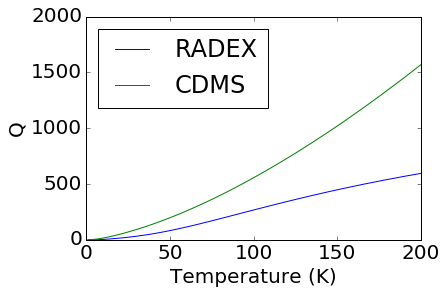

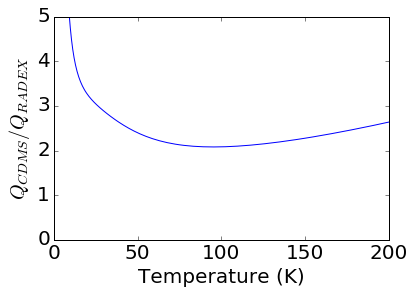

In [22]:
pl.plot(tems, Q_radex_1, label='RADEX')
pl.plot(tems, lte_model.Q, label='CDMS')
pl.axis((0,200,0,2000))
pl.legend(loc='best')
pl.ylabel("Q")
pl.xlabel("Temperature (K)")
pl.figure()
pl.plot(tems, lte_model.Q/Q_radex_1)
pl.axis((0,200,0,5))
pl.ylabel("$Q_{CDMS}/Q_{RADEX}$")
pl.xlabel("Temperature (K)")

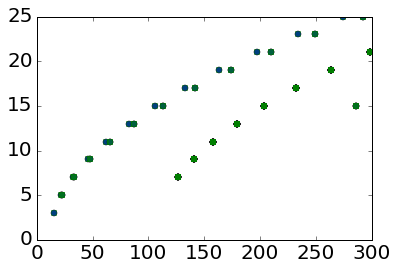

In [23]:
pl.plot(R_ph2co_h2.upperstateenergy, R_ph2co_h2.statistical_weight[R_ph2co_h2.upperlevelindex], 'o')
J = np.array([int(x.split("_")[0]) for x in R_ph2co_h2.quantum_number[R_ph2co_h2.upperlevelindex]])
gJ = 2*J+1
# RADEX assumes gI = 1, even though it's really 1/4
gI = 1 # for para
pl.plot(R_ph2co_h2.upperstateenergy, gJ*gI, 's', markeredgecolor='none', alpha=0.5)

In [24]:
print("RADEX/LAMDA has {0} transitions".format(len(R_ph2co_h2.upperlevelindex)))

RADEX/LAMDA has 107 transitions


In [32]:
import vamdclib

from vamdclib import nodes
from vamdclib import request as r
from vamdclib import specmodel as m

nl = nodes.Nodelist()
nl.findnode('cdms')
cdms = nl.findnode('cdms')

request = r.Request(node = cdms)


# Retrieve all species from CDMS
result = request.getspecies()
molecules = result.data['Molecules']

h2co = [x for x in molecules.values() if (x.StoichiometricFormula)==('CH2O') and x.MolecularWeight=='30'][0]

h2co_inchikey = h2co.InChIKey

# query everything for H2CO
query_string = "SELECT ALL WHERE VAMDCSpeciesID='%s'" % h2co.VAMDCSpeciesID
request.setquery(query_string)
result = request.dorequest()

m.calculate_partitionfunction(result.data['States'], temperature = 75.0)


{'XCDMS-116': 482.85001064741874}

In [162]:
h2co.VAMDCSpeciesID

'WSFSSNUMVMOOMR-UHFFFAOYSA-N'

In [66]:
def Q_vamdc(T):
    return m.calculate_partitionfunction(result.data['States'], temperature=T).values()[0]

In [67]:
print(m.calculate_partitionfunction(result.data['States'], temperature = 75.0))
print(Q_cdms(75))
print(Q_vamdc(75))

{'XCDMS-116': 482.85001064741874}
301.991179894
482.850010647


In [56]:
import requests
import bs4
# retrieve CDMS full frequency list
url = 'http://cdms.ph1.uni-koeln.de/cdms/tap/'
#rslt = requests.post(url+"/sync", data={'REQUEST':"doQuery", 'LANG': 'VSS2', 'FORMAT':'XSAMS', 'QUERY':"SELECT PROCESSES WHERE MoleculeInchiKey='WSFSSNUMVMOOMR-UHFFFAOYSA-N'"})
#bb_rad = bs4.BeautifulSoup(rslt.content, 'html5lib')
#print("CDMS has {0} transitions".format(rslt.headers['vamdc-count-radiative']))
#frequencies = np.array([float(x.value.text) for x in bb_rad.findAll('frequency')])
#upperstate = [x.text for x in bb_rad.findAll('upperstateref')]

rslt = requests.post(url+"/sync", data={'REQUEST':"doQuery", 'LANG': 'VSS2', 'FORMAT':'XSAMS', 'QUERY':"SELECT STATES WHERE MoleculeInchiKey='WSFSSNUMVMOOMR-UHFFFAOYSA-N'"})
bb_state = bs4.BeautifulSoup(rslt.content, 'html5lib')
qns = {x['stateid'][:13]: (int(x.case.find('asymcs:j').text),
                           int(x.case.find('asymcs:ka').text),
                           int(x.case.find('asymcs:kc').text),
                           )
       for x in bb_state.findAll('molecularstate')
       if 'origin' not in x['stateid']}
energies = {x['stateid'][:13]:
            float(x.molecularstatecharacterisation.stateenergy.value.text)
            for x in bb_state.findAll('molecularstate')
            if 'origin' not in x['stateid']}
print("CDMS has {0} states, of which we found {1} and {2} are unique and {3} have unique QNs"
      .format(rslt.headers['vamdc-count-states'], len(energies), len(set(qns.keys())), len(set(qns.values()))))

CDMS has 1795 states, of which we found 1795 and 1795 are unique and 1765 have unique QNs


In [63]:
(len([x['stateid'] for x in bb_state.findAll('molecularstate')]),
len([x['stateid'] for x in bb_state.findAll('molecularstate') if 'origin' not in x['stateid']]))

(1798, 1795)

In [80]:
print("CDMS: ",sum(energies.values()))
print("VAMDC:",sum([float(x.StateEnergyValue) for x in result.data['States'].values() if 'origin' not in x.StateID]))

('CDMS: ', 4042666.7440169966)
('VAMDC:', 4042666.7440169966)


In [111]:
degeneracies = np.array([(2*qns[st][0]+1)*(3 if qns[st][1]%2==1 else 1) for st in qns])
Ei = (np.array([energies[st] for st in qns])*u.cm**-1 *constants.h*constants.c/constants.k_B).to(u.K).value
print("N_energies={0}".format(len(Ei)))

N_energies=1795


('CDMS: ', 231815, 1795)
('VAMDC:', 231185.0, 1765)


(array([ 224.,  441.,  359.,  167.,  122.,  138.,  106.,  106.,   70.,   32.]),
 array([   1. ,   39.6,   78.2,  116.8,  155.4,  194. ,  232.6,  271.2,
         309.8,  348.4,  387. ]),
 <a list of 1 Patch objects>)

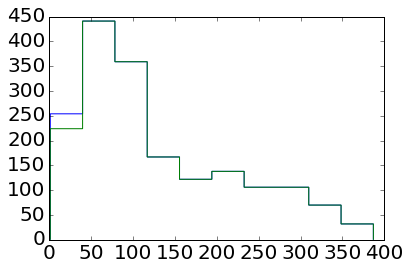

In [174]:
vamdc_deg = [float(x.TotalStatisticalWeight) for x in result.data['States'].values()
                    if 'origin' not in x.StateID  and 'F_H1 H2' not in x.QuantumNumbers.qn_dict]
vamdc_Ei = (np.array([(x.StateEnergyValue*u.Unit(x.StateEnergyUnit)*constants.h*constants.c/constants.k_B).to(u.K).value
                      for x in result.data['States'].values()
                      if 'origin' not in x.StateID  and 'F_H1 H2' not in x.QuantumNumbers.qn_dict]))
print("CDMS: ",sum(degeneracies), len(degeneracies))
print("VAMDC:",sum(vamdc_deg), len(vamdc_deg))
a,b= (np.array(degeneracies),np.array(vamdc_deg))
pl.hist(a, histtype='step')
pl.hist(b, histtype='step')

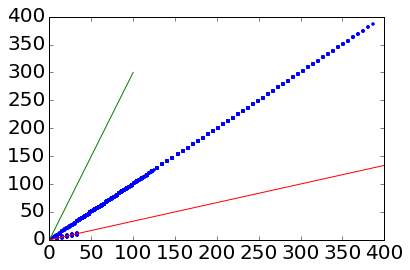

In [175]:
my_deg_map = {st:(2*qns[st][0]+1)*(3 if qns[st][1]%2==1 else 1) for st in qns}
sorted_statwt_mine = degeneracies = np.array([(2*qns[st][0]+1)*(3 if qns[st][1]%2==1 else 1) for st in qns])
vamdc_deg_map = {x.StateID:int(x.TotalStatisticalWeight) for x in result.data['States'].values()
                    if 'origin' not in x.StateID}
sorted_statwt_vamdc = [vamdc_deg_map[st] for st in qns]
pl.plot(sorted_statwt_mine, sorted_statwt_vamdc,'.')
pl.plot([0,100], [0,300])
pl.plot([0,400], [0,400/3.])

In [176]:
disagreed = [x for ii,x in enumerate(qns.keys()) if sorted_statwt_mine[ii] != sorted_statwt_vamdc[ii]]
#disagreed_states = [result.data['States'][st] for st in result.data['States']]

for st in disagreed:
    print("State={0}  QNs={1} (2J+1)*3or1={2:3d}  VAMDC_StatWt={3}"
          .format(st,
                  result.data['States'][st].QuantumNumbers.qn_string[20:],
                  my_deg_map[st],
                  vamdc_deg_map[st]))
[(st, qns[st], vamdc_deg_map[st], my_deg_map[st],
  result.data['States'][st].QuantumNumbers.qn_string[20:]) for st in disagreed]

State=SCDMS-8841335  QNs=J = 4; Ka = 1; Kc = 3; I_IH2 = 1; F_H1 H2 = 3;  (2J+1)*3or1= 27  VAMDC_StatWt=7
State=SCDMS-8841334  QNs=J = 3; Ka = 1; Kc = 2; I_IH2 = 1; F_H1 H2 = 3;  (2J+1)*3or1= 21  VAMDC_StatWt=7
State=SCDMS-8841337  QNs=J = 4; Ka = 1; Kc = 3; I_IH2 = 1; F_H1 H2 = 4;  (2J+1)*3or1= 27  VAMDC_StatWt=9
State=SCDMS-8841336  QNs=J = 4; Ka = 1; Kc = 3; I_IH2 = 1; F_H1 H2 = 5;  (2J+1)*3or1= 27  VAMDC_StatWt=11
State=SCDMS-8841331  QNs=J = 2; Ka = 1; Kc = 1; I_IH2 = 1; F_H1 H2 = 3;  (2J+1)*3or1= 15  VAMDC_StatWt=7
State=SCDMS-8841330  QNs=J = 2; Ka = 1; Kc = 1; I_IH2 = 1; F_H1 H2 = 2;  (2J+1)*3or1= 15  VAMDC_StatWt=5
State=SCDMS-8841333  QNs=J = 3; Ka = 1; Kc = 2; I_IH2 = 1; F_H1 H2 = 4;  (2J+1)*3or1= 21  VAMDC_StatWt=9
State=SCDMS-8841332  QNs=J = 3; Ka = 1; Kc = 2; I_IH2 = 1; F_H1 H2 = 2;  (2J+1)*3or1= 21  VAMDC_StatWt=5
State=SCDMS-8841339  QNs=J = 5; Ka = 1; Kc = 4; I_IH2 = 1; F_H1 H2 = 6;  (2J+1)*3or1= 33  VAMDC_StatWt=13
State=SCDMS-8841338  QNs=J = 5; Ka = 1; Kc = 4; I_IH2

[(u'SCDMS-8841335',
  (4, 1, 3),
  7,
  27,
  'J = 4; Ka = 1; Kc = 3; I_IH2 = 1; F_H1 H2 = 3; '),
 (u'SCDMS-8841334',
  (3, 1, 2),
  7,
  21,
  'J = 3; Ka = 1; Kc = 2; I_IH2 = 1; F_H1 H2 = 3; '),
 (u'SCDMS-8841337',
  (4, 1, 3),
  9,
  27,
  'J = 4; Ka = 1; Kc = 3; I_IH2 = 1; F_H1 H2 = 4; '),
 (u'SCDMS-8841336',
  (4, 1, 3),
  11,
  27,
  'J = 4; Ka = 1; Kc = 3; I_IH2 = 1; F_H1 H2 = 5; '),
 (u'SCDMS-8841331',
  (2, 1, 1),
  7,
  15,
  'J = 2; Ka = 1; Kc = 1; I_IH2 = 1; F_H1 H2 = 3; '),
 (u'SCDMS-8841330',
  (2, 1, 1),
  5,
  15,
  'J = 2; Ka = 1; Kc = 1; I_IH2 = 1; F_H1 H2 = 2; '),
 (u'SCDMS-8841333',
  (3, 1, 2),
  9,
  21,
  'J = 3; Ka = 1; Kc = 2; I_IH2 = 1; F_H1 H2 = 4; '),
 (u'SCDMS-8841332',
  (3, 1, 2),
  5,
  21,
  'J = 3; Ka = 1; Kc = 2; I_IH2 = 1; F_H1 H2 = 2; '),
 (u'SCDMS-8841339',
  (5, 1, 4),
  13,
  33,
  'J = 5; Ka = 1; Kc = 4; I_IH2 = 1; F_H1 H2 = 6; '),
 (u'SCDMS-8841338',
  (5, 1, 4),
  9,
  33,
  'J = 5; Ka = 1; Kc = 4; I_IH2 = 1; F_H1 H2 = 4; '),
 (u'SCDMS-8841326'

In [177]:
def Q_cdms(T):
    return (vamdc_deg*np.exp(-vamdc_Ei/(T))).sum()

In [178]:
h2co = result.data['Molecules']['XCDMS-116']
h2copf = h2co.PartitionFunction[0]
h2copfmap = dict(zip(h2copf.PartitionFunctionT, h2copf.PartitionFunctionQ))
print("Computed: {0}  Tabulated: {1}"
      .format(m.calculate_partitionfunction(result.data['States'], temperature = 25.704),
              h2copfmap['25.704']))

Computed: {'XCDMS-116': 121.40960234969852}  Tabulated: 72.8912667217


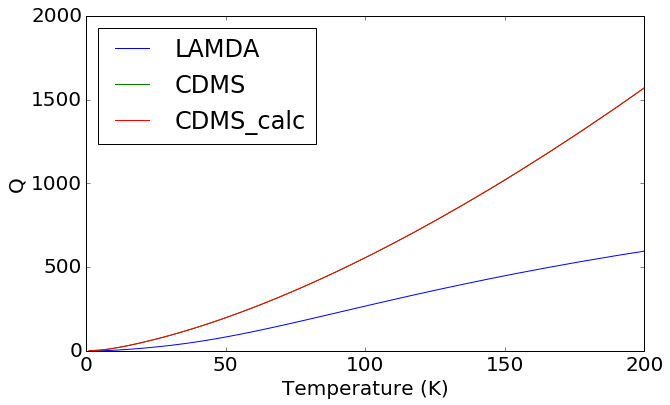

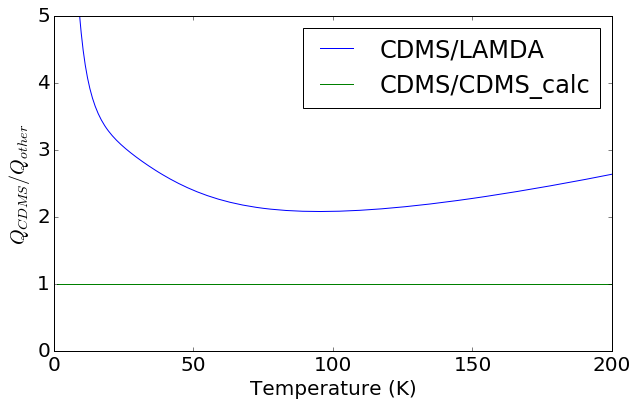

In [179]:
q_cdms_calc = np.array([Q_cdms(T) for T in tems])
pl.figure(figsize=(10,6))
pl.plot(tems, Q_radex_1, label='LAMDA')
pl.plot(tems, lte_model.Q, label='CDMS')
pl.plot(tems, q_cdms_calc, label='CDMS_calc')
pl.axis((0,200,0,2000))
pl.legend(loc='best')
pl.ylabel("Q")
pl.xlabel("Temperature (K)")
pl.figure(figsize=(10,6))
pl.plot(tems, lte_model.Q/Q_radex_1, label='CDMS/LAMDA')
pl.plot(tems, lte_model.Q/q_cdms_calc, label='CDMS/CDMS_calc')
pl.axis((0,200,0,5))
pl.ylabel("$Q_{CDMS}/Q_{other}$")
pl.xlabel("Temperature (K)")
pl.legend(loc='best')


## Column Density Comparison ##

First, a sanity check: Does "observing" the LTE forward model recover the input column density?

In [30]:
Qrot = lambda x: np.interp(x.to(u.K).value if hasattr(x,'to') else x, lte_model.tem, lte_model.Q)
ph2co_303 = lte_model.ph2co_303
ph2co_303['dnu'] = (1*u.km/u.s/constants.c * ph2co_303['frequency']).decompose()
ph2co_303['tex'] = 50*u.K
ph2co_303['partition_function'] = Qrot(ph2co_303['tex'])

modeled_brightness = lte_model.line_brightness(**ph2co_303)

derived_column = Nthintot(nu=ph2co_303['frequency'],
                          line_integral=modeled_brightness*u.km/u.s,
                          degeneracy_u=ph2co_303['degeneracy'],
                          line_strength=ph2co_303['dipole_moment'],
                          temperature=ph2co_303['tex'],
                          Eu=ph2co_303['energy_upper'],
                          Tex=ph2co_303['tex'],
                          ).to(u.cm**-2)
tauperdnu = lte_model.line_tau(**{k:v for k,v in ph2co_303.items() if k!='dnu'}).decompose()
print("tau/dnu: {0}, tau_1kms: {1}".format(tauperdnu, tauperdnu/ph2co_303['dnu']))
print("derived_column: {0}, input column: {1}, ratio der/in: {2}".format(derived_column, ph2co_303['total_column'],
                                                                         derived_column/ph2co_303['total_column']))

tau/dnu: 669.664770448 1 / s, tau_1kms: 0.000919981820221
derived_column: 9.99551276953e+11 1 / cm2, input column: 1e+12 1 / cm2, ratio der/in: 0.999551276953
